<a href="https://colab.research.google.com/github/anhquan-truong/PM520/blob/main/HW/PM520_HW1_AnhQuanTRUONG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1. Linear regression and normal equations

In [1]:
import jax
import jax.numpy as jnp
import jax.random as rdm
import jax.numpy.linalg as jnpla
import matplotlib.pyplot as plt


# 1. Linear model simulation
In class we defined a Python function that simulates $N$ $P\times 1$ variables $X$ (i.e. an $N \times P$ matrix $X$) and outcome $y$ as a linear function of $X$. Please include its definition here and use for problem 2.

Given $N \times P$ matrix $X$, a $P \times 1$ vector $a$, and $N \times 1$ outcome vector $y$, we can describe the $y$ as a linear function of $X$ as $$X\times a =y.$$

[  0 912]
Coefficent: 
 [-0.5637999  -1.8917723  -0.93777573 -0.6846789  -1.3029882  -1.4445065
 -0.0831802  -0.5717276  -0.05326677 -0.75262386]
X: 
 [[ 9.78295326e-01  1.95481300e-01 -6.36324137e-02 -1.19514860e-01
   9.69143271e-01  1.23896575e+00 -2.46778373e-02 -1.17127156e+00
  -2.41714958e-02  6.90482184e-02]
 [-1.01228237e-01 -1.56527174e+00  1.53149748e+00 -1.22568011e+00
   1.23616314e+00 -1.36260200e+00  7.59347200e-01 -1.21615314e+00
   6.63175702e-01 -1.63152790e+00]
 [ 6.32267177e-01  1.98796429e-02 -3.17569345e-01 -1.52542663e+00
  -1.22800899e+00  1.20095301e+00  2.09387612e+00 -1.87825561e+00
   1.46584749e+00  8.72788489e-01]
 [ 2.73664277e-02 -2.39281684e-01  7.32922405e-02  1.62833297e+00
   7.59546459e-01  8.70356023e-01 -3.86531115e-01  5.30242383e-01
  -1.32814491e+00  3.78911883e-01]
 [ 2.45779932e-01 -1.54922593e+00 -3.14407527e-01  8.09150875e-01
   5.49369216e-01 -1.12930250e+00 -1.67901659e+00 -9.01744545e-01
   2.87337452e-01 -1.64711404e+00]
 [-1.58247933e

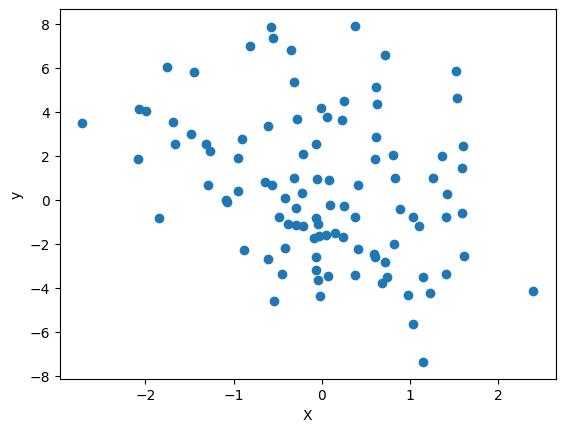

In [ ]:
def sim_linear_reg(key, N, P, r2=0.5):
  key, x_key = rdm.split(key)
  a = rdm.normal(key, shape=(P,))
  X = rdm.normal(x_key, shape = (N, P))
  y = X @ a
  return a, X, y

seed = 912
key = rdm.PRNGKey(seed) # creating key from seed
print(key) # Print only the single key

N = 100 # variables
P = 10 # dimensions - or number of features

a, X, y = sim_linear_reg(key, N, P, r2=0.5)
print(f"Coefficent: \n {a}")
print(f"X: \n {X}")
print(f"Y: \n {y}")

plt.scatter(X[:, 2], y)
plt.xlabel("X")
plt.ylabel("y")
plt.show()

# 2. Just-in time decorator and ordinary least squares
Complete the definition of `ordinary_least_squares` below, that estimates the effect and its standard error. `@jit` wraps a function to perform just-in-time compilation, which boosts computational performance/speed.

Compare the times of with and without JIT
Hint: use [`block_until_ready()`](https://jax.readthedocs.io/en/latest/_autosummary/jax.block_until_ready.html) to get correct timing estimates.

In [ ]:
import jax

from jax import jit


def ordinary_least_squares(X, y):
  """
  computes the OLS solution to linear system y ~ X.
  Returns a tuple of $\hat{beta}$ and $\text{se}(\hat{beta})$.
  """

  pass

jit_ordinary_least_squares = jit(ordinary_least_squares)

# 3. OLS derivation
Assume that $y = X \beta + \epsilon$ where $y$ is $N \times 1$ vector, $X$ is an $N \times P$ matrix where $P < N$ and $\epsilon$ is a random variable such that $\mathbb{E}[\epsilon_i] = 0$ and $\mathbb{V}[\epsilon_i] = \sigma^2$ for all $i = 1 \dots n$. Derive the OLS "normal equations".

The goal is to find $\beta$ such that the residual sum of square is minimal. The $RSS(\beta)$ is

$$RSS(\beta)=\sum_{i=1}^n (y_i - x_i^T\beta)^2$$

We want to find

$$\beta^*=argminRSS(\beta)$$

**Approach**: We find stationary point, i.e. the point with zero gradients. We take the derivative of $RSS(\beta)$ with respect to $\beta$

$$
\begin{align*}
\frac{\partial RSS(\beta)}{\partial \beta} &= 2\sum_{i=1}^n (x_i^T\beta-y_i)x_i \\
&=2\sum_{i=1}^n (x_i^T x_i \beta - x_i y_i) \\
&=2\sum_{i=1}^n (x_i^T \beta x_i - x_i y_i) \\
&=2\sum_{i=1}^n (x_i x_i^T) \beta - 2\sum_{i=1}^n (x_i y_i) \\
&=2\sum_{i=1}^n (x_i x_i^T) \beta - 2\sum_{i=1}^n (x_i y_i) \\
&=2[(X X^T) \beta - (X Y)] \\
\end{align*}
$$

From that we have
$$
\begin{align*}
\nabla RSS(\beta) &= 0 \iff 2[(X X^T) \beta - (X Y)]  = 0 \iff \beta = (XX^T)^{-1} (XY)\\
\end{align*}
$$

assuming $(XX^T)^{-1}$ is invertible.
